# Dynamic Time Warping with BitCoin

## BitCoin
비트코인이 난리다. 1코인당 2천만원을 넘긴 2017년에는 벼락부자 스토리가 들리더니, 2018년 2월 들어 800만원까지 폭락했다. 이더리움 등 나머지 코인도 비슷한 폭락세를 그리거나 거래소에서 사라지는 경우도 발생하고 있다.

비트코인이 떡상하거나 떡락할때마다 뉴스나 커뮤니티에 등장하는 차트가 있다.

![Hyman Minsky Bubble Chart](hyman_minsky_bubble.png)


흔히 '하이먼 민스키 차트'라고 부르는 이 차트는 버블이 만들어지고 터지기까지의 그 일대기를 일반화해서 보여준다. 버블이 터지면서 급작스럽게 자산 가치가 폭락하는 시점을 'Minsky Moment'라 한다.

변동성이 하도 크다보니 가격 대폭락이 민스키 모먼트인지 아니면 그 중간에 잠시 쉬어가는 곳인지 판단이 잘 서지 않는다. 그러다보니 비트코인이 떨어질때나 다시 오를때나 하이먼 민스키 차트가 등장하며 그 현상을 서포트하는 증거로 쓰인다. (이제 폭락 vs. 아직 버블은 멀었다)

경제학자 하이먼 민스키는 생전에 그리 유명한 학자는 아니었다고 한다. 2007년 서브 프라임 모기지 버블이 터지면서 미디어가 민스키의 경제 공황 이론에 주목했다한다[2]. 이제는 그 이름이 2018년 대한민국 인터넷 판을 뜨겁게 달구고 있으니 흐뭇하실지 아닐지 모르겠다.

![Hyman Minsky](hyman.jpg)


어쨌든 GPU를 쓰기만 할 뿐 NVIDIA 주식을 살 생각을 전혀 못하는 나는 이번에도 비트코인의 파도를 그저 바라만 보았고, 보다보니 공부나 할 겸 Dynamic Time Warping을 적용해보기로 했다.

## Sequence Similarity

하이먼 민스키의 차트로 다시 돌아가보자. 사람들이 얘기하듯 정말 비트코인이나 다른 암호화폐는 그가 이론화한 버블의 흐름을 따라가는 걸까? 
비트코인 가격의 시계열 흐름과 하이먼 민스키 그래프 상의 흐름을 비교해보면 되겠다.

미리 준비된 데이터를 통해 그래프로 살펴보자.

하이먼 민스키 데이터는 차트 이미지를 <a href="https://automeris.io/WebPlotDigitizer/">WebPlotDigitizer</a>라는 툴에 집어넣어 데이터 포인트를 추출했다. 

In [1]:
## 일단 필요한 라이브러리를 불러온다.
import coin_crawler
import os
import numpy as np
import pandas as pd
from fastdtw import fastdtw
import _ucrdtw
import glob
import re
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import euclidean

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

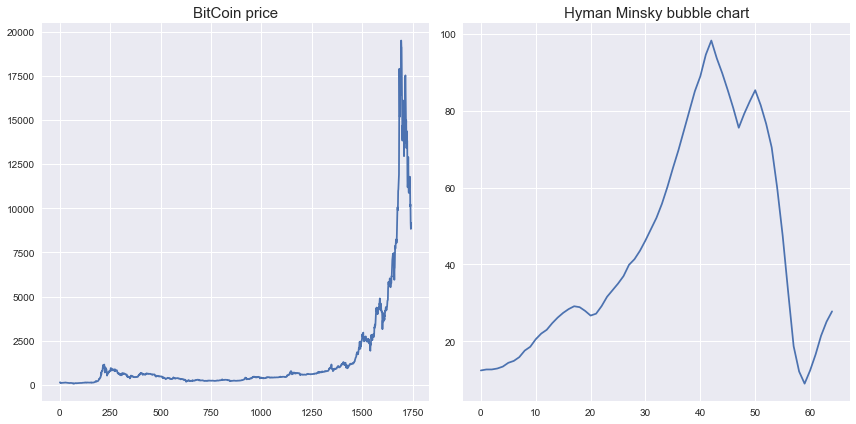

In [2]:
## 비트코인 데이터와 하이먼 민스키 데이터를 불러와
## 비트코인 종가와 민스키 그래프를 그린다.
bitcoin_path = 'dataset/bitcoin.csv'
minsky_path = 'HymanMinsky.csv'

bitcoin_df = pd.read_csv(bitcoin_path)
bitcoin_df['Date'] = bitcoin_df['Date'].map(pd.to_datetime)
minsky_df = pd.read_csv(minsky_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(bitcoin_df.Close)
ax[1].plot(minsky_df.y)

ax[0].set_title("BitCoin price", fontsize=15)
ax[1].set_title("Hyman Minsky bubble chart", fontsize=15)

plt.tight_layout()
plt.show()

그래프를 보면 정말 비트코인 가격의 흐름이 하이먼 민스키 차트와 비슷하게 보인다! 다만 초반의 긴 보합세로 인해서 비트코인은 우측으로 심하게 쏠려있다.

여기서 어떻게 두 시계열의 유사성을 비교할 수 있을까? 가장 쉬운 방법은 time series 데이터간에 correlation을 구하는 방법이 되겠다. [3]의 조언을 따라 numpy의 corrcoef함수를 써보자!

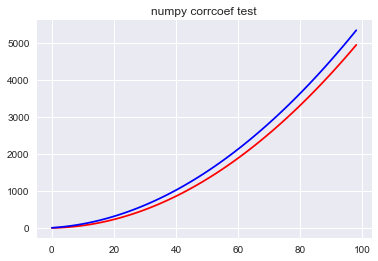

In [3]:
## 함수 테스트

a = np.arange(1, 100).cumsum()
b = np.arange(5, 104).cumsum()

fig, ax = plt.subplots()
ax.plot(a, color='r')
ax.plot(b, color='b')

ax.set_title("numpy corrcoef test")
plt.show()

In [4]:
np.corrcoef([a, b])

array([[ 1.        ,  0.99984636],
       [ 0.99984636,  1.        ]])

샘플로 만들어본 a와 b는 육안으로 봐도 매우 상관성이 높아보이고, numpy.corrcoef로 뽑아봐도 지표가 0.999로 매우 높은 양의 상관관계를 가진다.

그런데 이 방식은 내가 준비한 비트코인 데이터에 바로 쓰지 못한다. numpy.corrcoef는 두 시계열 데이터의 길이가 같아야 하는데, 비트코인은 약 1800개, 하이먼민스키는 70여개 데이터포인트로 그 차이가 매우 심하다.

그럼 하이먼민스키를 길게 늘려서 비교하면 되지 않을까? 인덱스를 길쭉하게 뜯어놓는 방식으로 민스키 데이터 포인트를 늘린 다음, numpy.interp를 사용해서 linear interpolation으로 중간을 메워보자[4].

In [5]:
hm_datapoints = len(minsky_df.y)
bc_datapoints = len(bitcoin_df.Close)

In [6]:
every = bc_datapoints // hm_datapoints
stretched = np.zeros(bc_datapoints)
for hd in range(hm_datapoints):
    stretched[hd * every] = minsky_df.y.iloc[hd]

stretched[-1] = minsky_df.y.iloc[-1]
stretched[np.where(stretched == 0)] = np.nan

In [7]:
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

nans, x = nan_helper(stretched)
stretched[nans] = np.interp(x(nans), x(~nans), stretched[~nans])

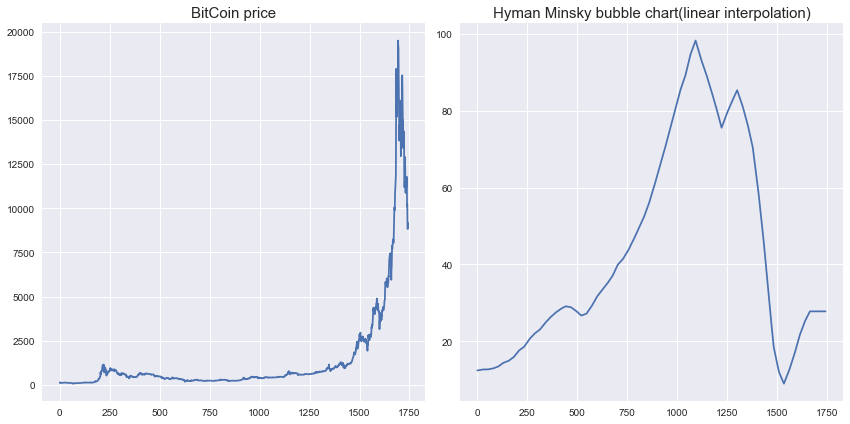

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(bitcoin_df.Close)
ax[1].plot(stretched)

ax[0].set_title("BitCoin price", fontsize=15)
ax[1].set_title("Hyman Minsky bubble chart(linear interpolation)", fontsize=15)

plt.tight_layout()
plt.show()

길이가 같아졌으니 np.corrcoef를 돌려볼 수 있다.

In [9]:
np.corrcoef([bitcoin_df.Close, stretched])

array([[ 1.       , -0.2074127],
       [-0.2074127,  1.       ]])

corrcoef값은 -0.206으로 상관성이 거의 없다고 나온다. y축을 sklearn의 MinMaxScaler를 사용해 0과 1 사이로 맞추고 돌려도 결과는 같게 나온다. 왜 그런걸까?

사실 우리가 이 두 차트를 보고 비슷하다고 느끼는 것은 데이터 포인트가 정확히 일치하거나 같은 시점에 그 성장폭이 같아서가 아니다. 두 차트 모두 길고 지루한 성장기와 급격한 폭발과 떡락이라는 특징을 가지고 있다. 즉 시간 스케일에 관계없이 두 시퀀스간의 유사성을 파악해야 한다. 이때 쓸수 있는 도구가 바로 'Dynamic Time Warping'이다.

## Dynamic Time Warping

용어 이름에 '다이나믹'이라는 표현이 들어가면 난이도가 급상승하는 느낌이다. Dynamic Time Warping은 음성 인식(automatic speech recognition)에서 사용되던 기법으로, 두 시퀀스간의 최적의 정렬(alignment)를 구하는데 사용한다. 그 이름에서 드러나듯, 시계열 데이터의 '시간'을 왜곡하는 기법으로, 시퀀스의 길이나 속도에 관계없이 사용할 수 있는 장점이 있다.

![Dynamic Time Warping](dtw.png)

Meinard Müller가 집필한 Information Retrieval for Music and Motion[5]의 챕터 4에서 몇가지 중요 내용을 가져와 정리해둔다.

### Cost Matrix

시퀀스 X와 Y가 있다고 하자. 이 둘을 x와 y축에 늘어놓고 데이터 포인트간의 거리(유클리디언 거리같은)를 구하면 그 값은 어떤 매트릭스가 된다.

![Cost Matrix and optimal Path](cost_matrix.png)

그 매트릭스를 히트맵으로 표현하면 위 그림처럼, 두 데이터 포인트간 거리가 짧은 곳은 어둡게, 거리가 먼 곳은 흰색으로 표현된다. DTW는 저 코스트 매트릭스상의 좌하단에서 우상단까지 가는 최적의 경로를 찾는 문제를 푼다.

### Contraints

그런데 몇가지 조건이 있다. 

![3 constraints](constraints.png)

1) 두 시퀀스의 처음과 끝은 같아야 한다. 즉 무조건 좌하단에서 시작해서 우하단에서 끝난다.  
2) x나 y축, 혹은 그 두 축에서 음의 방향으로 이동하지 않는다.  
3) 이동할때 정해진 스텝사이즈((0,1) or (1,0) or (1,1))만큼 이동한다.  


3번 조건은 경우에 따라 경로 검색 효율성을 높이기 위해 바뀌기도 한다. DTW는 결국 X와 Y를 늘어놓고 X의 특정 데이터포인트가 Y의 어떤 데이터포인트에 가장 적합한지를 판정하는 로직이므로, X와 Y의 길이가 늘어나면 늘어날수록 검색 비용이 들어간다.

무작정 비교하는 것은 매우 효율이 떨어지고 속도도 느리다. 게다가 전후 경로만 보고 기계적으로 두 시퀀스를 정렬시켜버리는 "pathological alignment"를 피해기 위해 여러 장치를 사용하는데, 이 중 자주 쓰이는 것이 "Sakoe-Chiba Band"와 "Itakura Parallelogram"이다. 

![global constraints](sakoe.png)


Sakoe-Chiba Band는 대각선을 기준으로 허용하는 width T를 정해두고, 경로가 이를 벗어나지 않도록 강제한다. Itakura Parallogram은 S를 사용해 경로의 기울기가 1/S ~ S 사이에 위치하도록 하는 장치다. 이러한 기법을 사용하면 서치 스페이스를 크게 줄여 속도와 퀄리티를 개선할 수 있다. 하지만 세번째 그림처럼 옵티멀한 정렬이 강제 범위 밖에 위치할 수도 있다.


## DTW in Python

그럼 일단 이론은 여기까지 보고, 파이썬으로 어떻게 DTW를 사용할 수 있는지 보자. 예전부터 연구가 많이 이루어진 분야다보니 numpy나  scipy로 구현한 사례를 구글에서 어렵지 않게 찾아볼 수 있고, pip로 설치할 수 있는 라이브러리도 있다. 'python DTW'로 검색하면 'fastdtw'라는 라이브러리가 가장 먼저 나온다.

fastdtw는 2007년 나온 'FastDTW: Toward Accurate Dynamic Time Warping in Linear Time and Space' 논문을 구현한 파이썬 라이브러리다. 논문에 의하면 FastDTW는 기존의 DTW에 비해 효율성을 개선하였으며, 기존 추정방식인 Sakoe-Chiba Bands나 Data Abstraction에 비해 더 높은 정확도를 보여준다고 한다.

fastdtw를 사용해 하이먼 민스키를 비트코인에 맞춰보자.
비트코인의 종가를 그대로 집어넣으면 하이먼민스키의 y와 스케일이 너무 달라 결과가 제대로 피팅되지 않는다. sklearn의 MinMaxScaler를 사용해 둘다 0과 1 사이로 맞춰준다.

In [10]:
mns = MinMaxScaler()

bitcoin_df['adj_close'] = mns.fit_transform(bitcoin_df.Close)
minsky_df['adj_y'] = mns.fit_transform(minsky_df.y)

distance, path = fastdtw(bitcoin_df.adj_close, minsky_df.adj_y, dist=euclidean)

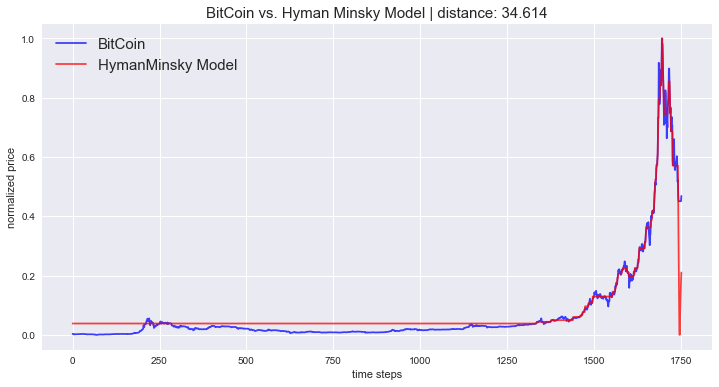

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot([bitcoin_df.adj_close.iloc[v] for v in [p[0] for p in path]], color='b', label='BitCoin', alpha=0.75)

ax.plot([minsky_df.adj_y[v] for v in [p[1] for p in path]], color='r', label='HymanMinsky Model', alpha=0.75)

ax.legend(fontsize=15)
ax.set_title("BitCoin vs. Hyman Minsky Model | distance: {}".format(round(distance, 3)), fontsize=15)
ax.set_xlabel("time steps")
ax.set_ylabel("normalized price")

plt.show()

그럴듯하게 들어맞는 그림이다. 지금 우리가 보는 비트코인 가격의 급락은 Minsky Moment가 정말 맞는걸까? 아직 민스키 그래프만큼 비트코인 가격이 내려오지는 않았으므로 또다른 떡상을 위한 숨고르기일 수도 있겠다(feat. 행복회로)

![행복하다.](happiness_circuit.gif)


Cost Matrix에서 DTW가 찾은 옵티멀한 패스는 어디였을까?

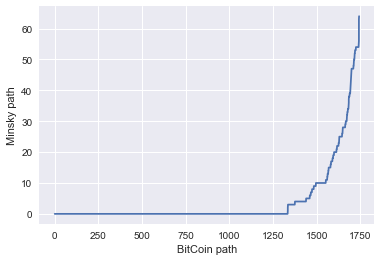

In [14]:
bitcoin_path = [p[0] for p in path]
minsky_path = [p[1] for p in path]

plt.plot(bitcoin_path, minsky_path)
plt.xlabel("BitCoin path")
plt.ylabel("Minsky path")
plt.show()

앞서 봤던 그래프에서 비트코인은 긴 성장기로 인해 우측으로 그래프 변동이 쏠려있었다. 이를 보정하기 위해 DTW는 Minsky 그래프의 초반 구간을 쭉 늘인 후 뒷부분을 매칭시켰다. 

## Finding subsequences

비트코인 차트는 하이먼 민스키를 따라가는 것 같으면서도 마지막에 그렇지 않을수도 있다는 일말의 희망을 남긴다. 끝날때까지 끝난게 아닐 수도 있다. 또 하이먼민스키 차트는 다음과 같이 하이먼 민스키의 원래 의도를 공격하기도 한다.

![하이먼민스키하이먼민스키 by 클리앙](HymanMinsky_inf.png)

사실 이게 꽤 그럴듯 한 것이, 1~2년 전에 해외 비트코인 거래소 대표의 자살, 해킹 등 각종 악재가 있었고, 이로 인해 비트코인 가격이 폭락할때마다 민스키 차트가 게시판에 올라왔었다. 일시적인 폭락에도 불구하고 비트코인 가격은 다시 이전 상태를 회복하고 또 다른 고점을 향해 달려갔다. 그렇다면 비트코인 가격의 흐름은 실제로 여러개의 작은 하이먼 민스키 그래프로 구성되어있을까?

우리가 찾고자 하는 하이먼 민스키 패턴을 'query'로, 탐색하려는 전체 비트코인 그래프를 'database'로 설정한 다음, database를 여러 구간('subsequence')으로 잘게 자르고, 'query'와 'subsequence'간의 distance를 DTW로 산출하는 방식을 사용해보자. 

DTW를 subsequence pattern recognition에 적용한 방식을 찾다보니 ucrdtw[7]를 발견하게 되었는데, 기존 방식들에 비해 속도도 훨씬 빠르다고 한다. 2012년에 SIGKDD 베스트 페이퍼를 받았다고 하니 믿고 써보자. 게다가 친절하게 python으로 만들어둔 라이브러리(https://github.com/klon/ucrdtw)도 있다. 문서화가 잘 안되어있기는 한데, 함수도 하나뿐이고, threshold만 정하면, 해당 query에 일치하는 구간의 index location과 distance를 뽑아준다.

단, 비교할 subsequence 구간의 길이를 어느정도로 할지 정해줘야 하는 단점이 있는 듯 하다.

In [15]:
def find_subsequences(data, query):

    res = []

    def run_ucrdtw(data, query):
        
        ## 최초 300개 데이터 포인트 정도만 스캔한다.
        loc, dist = _ucrdtw.ucrdtw(data.Close.values[:300], query.y.values, 0.05, False)
        
        ## distance가 5 이하인 경우에만 일치하는 시퀀스로 판정한다.
        if dist < 5:
            tdata = data.iloc[loc:loc+len(query)]
            tdata['startDate'] = tdata.Date.iloc[0]
            res.append(tdata)
            
        loc = len(query)

        ## 스캔할 데이터 포인트가 30개 이상이면 시퀀스 탐색을 지속한다.
        if len(data.iloc[loc:]) > 30:
            run_ucrdtw(data.iloc[loc:], query)
            
    run_ucrdtw(data, query)     
    
    tmp = reduce(lambda x, y: x.append(y), res)
    tmp = tmp.drop_duplicates()
    tmp['Date'] = tmp['Date'].map(pd.to_datetime)
    tmp.set_index('Date', inplace=True)
    
    return tmp


In [16]:
bitcoinSub = find_subsequences(bitcoin_df, minsky_df)

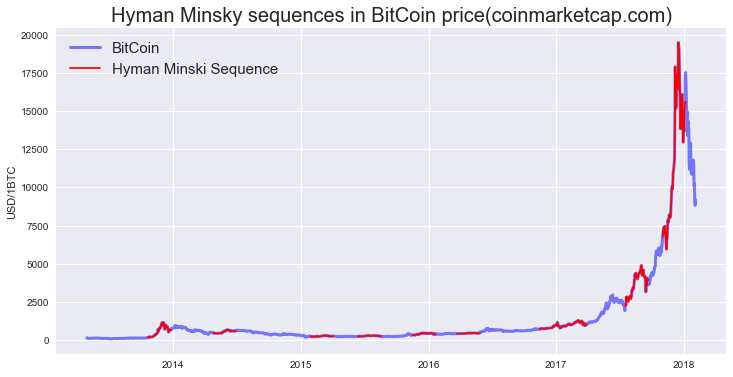

In [17]:
idx = pd.date_range(bitcoin_df.Date.iloc[0], bitcoin_df.Date.iloc[-1])
bitcoinSub2 = bitcoinSub.reindex(idx, fill_value=None)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(bitcoin_df['Date'], bitcoin_df.Close, 'b', alpha=0.5, linewidth=3, label='BitCoin')
ax.plot(bitcoinSub2.Close.fillna(limit=2, method='ffill'), 'r', label='Hyman Minski Sequence')

ax.legend(fontsize=15)
plt.title("Hyman Minsky sequences in BitCoin price(coinmarketcap.com)", fontsize=20)
plt.ylabel("USD/1BTC")
plt.show()

시퀀스 추출결과 재밌는 결과가 나온다. 짤방처럼 하이먼 민스키 그래프가 앞뒤로 붙어있지는 않지만, 약 3~6개월 간격으로 반복되는 것처럼 보인다. 마지막 패턴이 12월에 끝나니, 3월~5월 사이에 비트코인을 사면 올라갈까 궁금하다. 어쨌든 실제로 추출한 구간이 얼마나 비슷한지 살펴보자.

In [16]:
g = bitcoinSub.groupby('startDate')

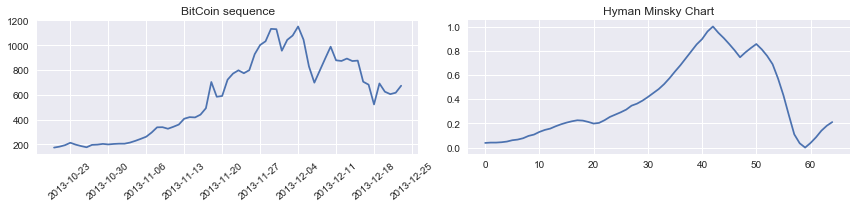

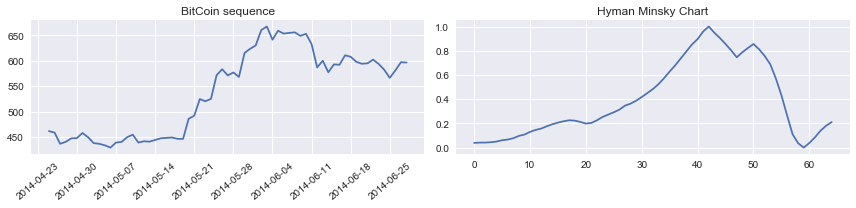

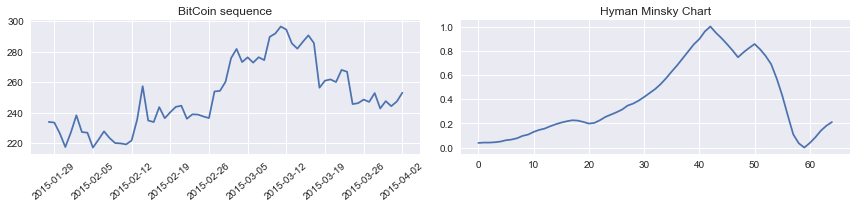

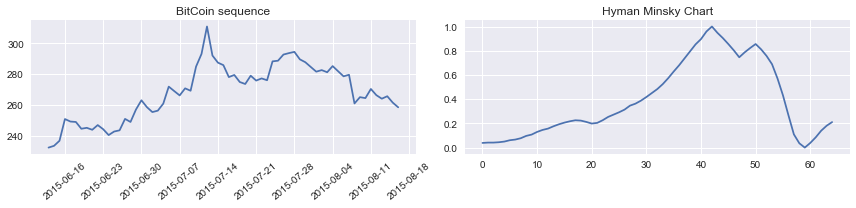

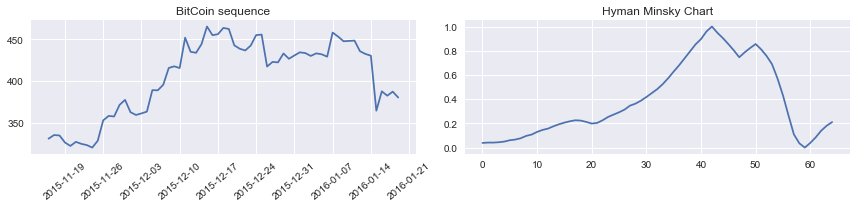

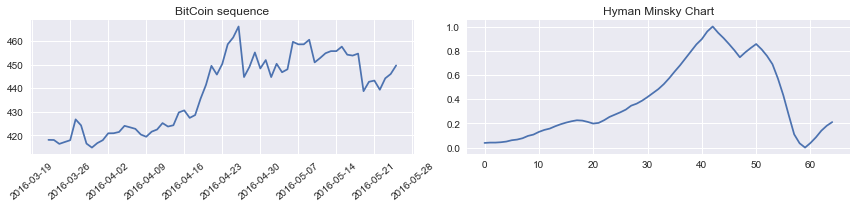

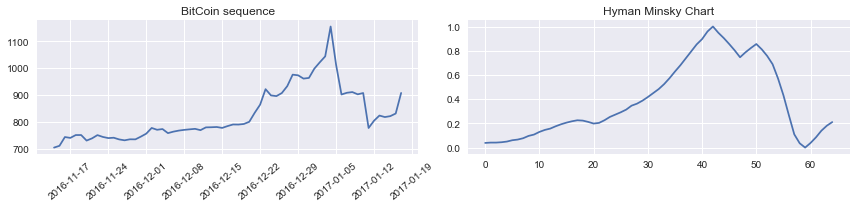

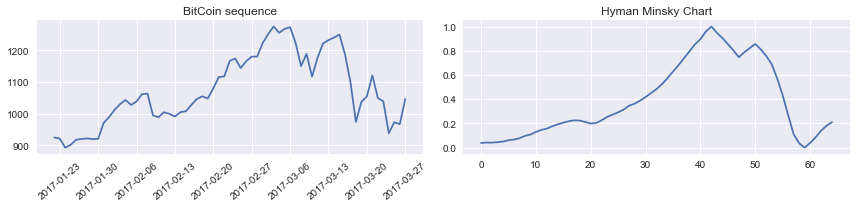

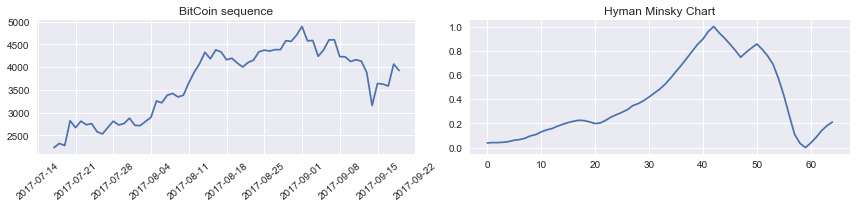

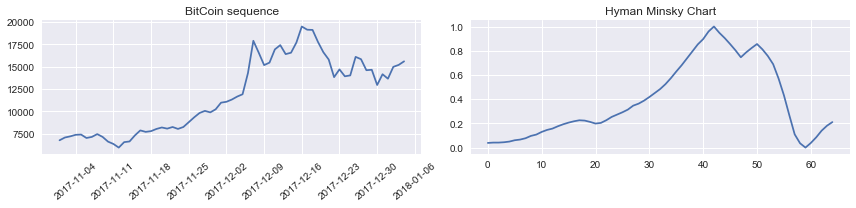

In [17]:
for label, data in g:
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    ax[0].plot(data.Close)
    ax[1].plot(minsky_df.adj_y)
    ax[0].set_title("BitCoin sequence")
    ax[1].set_title("Hyman Minsky Chart")
    for tick in ax[0].get_xticklabels():
        tick.set_rotation(40)
    plt.tight_layout()
    plt.show()

일부 차트는 최종 대폭락 구간이 약간 애매하긴 하지만, 전반적으로 성장->약 정체->급성장->폭락->반등->대폭락의 패턴을 보인다. 재미있는 점은 요새 이슈가 되고 있는 2017년 11월 ~ 2월 구간이 민스키 시퀀스로 추출되지 않았다는 점이다. 해당 시점의 그래프를 찍어보면 다음과 같다.

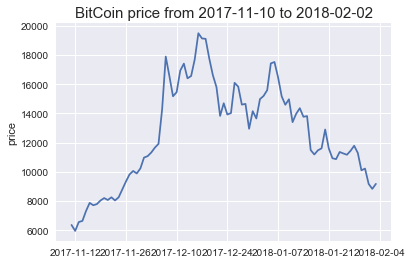

In [18]:
fig, ax = plt.subplots()
ax.plot(bitcoin_df[lambda x: x.Date > '2017-11-10'].Date, bitcoin_df[lambda x: x.Date > '2017-11-10'].Close)
ax.set_title("BitCoin price from 2017-11-10 to 2018-02-02", fontsize=15)
ax.set_ylabel("price")
plt.show()

하이먼 민스키 그래프와는 다르게 최고점 이후 2번 이상 하강-반등하다보니 민스키 그래프와 distance가 벌어졌던 모양이다.

## 그래서 저점은 어디인가?
실존하는 회사의 자산가치에 연동되어 있는 주식과 달리 비트코인은 그 가치를 보증하는 것이 없다. 그래서 본질적 가치에 기반한 저점을 산출하는 것은 의미가 없지 않나 싶다. 비트코인이 앞으로 하이먼민스키 차트와 비슷한 패턴으로 이동한다면, 대략 기다려야할 가격대를 알 수 있지 않을까?

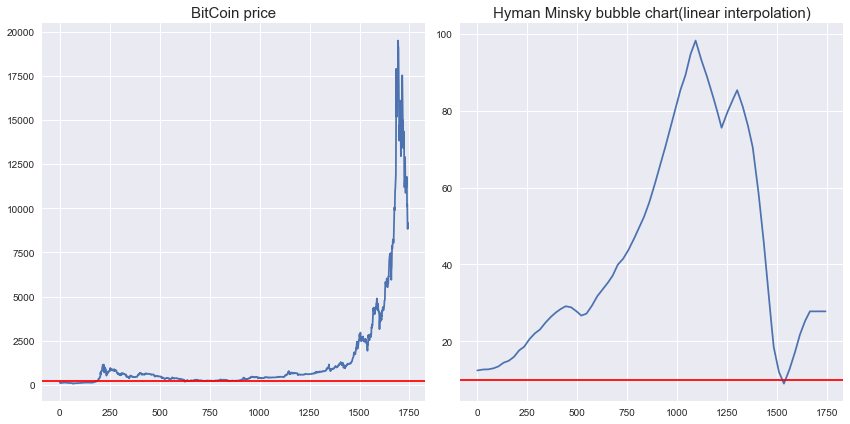

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(bitcoin_df.Close)
ax[1].plot(stretched)

ax[0].set_title("BitCoin price", fontsize=15)
ax[1].set_title("Hyman Minsky bubble chart(linear interpolation)", fontsize=15)

ax[0].axhline(y=200, color='r', linestyle='-')
ax[1].axhline(y=10, color='r', linestyle='-')

plt.tight_layout()
plt.show()

눈대중으로 저점은 약 200달러 언저리에 위치한다고 볼 수 있겠다. 200달러에 사서 반등의 기회를 노려 2000달러에 팔면 10배의 차익을 거둘 수 있으니, 아직 기회는 남은 셈이다.(미침)

![행복하다.](happiness_circuit.gif)




## 회로에는 여전히 99개의 코인이 남아있다.

비트코인만이 유일한 암호화폐는 아니다. 개중에는 하이먼 민스키 패턴을 보이지 않는 것도 있을 것이며, 아직 떡상의 패턴을 보이지 않았다면 대박의 기회는 남아있다! coinmarketcap.com에서 나머지 데이터도 긁어와서 테스트해보자. BeatifulSoup을 사용해 간단한 크롤러를 만든 후, 첫 페이지에 올라온 100개의 주요 코인 데이터를 받아와 csv로 저장한다. 해당 코드는 `coin_crawler.py`에 구현해두었다.

In [20]:
if not os.path.exists("dataset"):
    os.makedirs("dataset")

In [21]:
currencies = coin_crawler.crawl_currency_names(1)

In [22]:
for cur in currencies:
    currency = coin_crawler.currency(cur)
    currency.data.to_csv("dataset/{}.csv".format(cur))
    print("Done: currency {} -> csv".format(cur))

Done: currency bitcoin -> csv
Done: currency ethereum -> csv
Done: currency ripple -> csv
Done: currency bitcoin-cash -> csv
Done: currency cardano -> csv
Done: currency litecoin -> csv
Done: currency stellar -> csv
Done: currency neo -> csv
Done: currency nem -> csv
Done: currency iota -> csv
Done: currency dash -> csv
Done: currency monero -> csv
Done: currency lisk -> csv
Done: currency ethereum-classic -> csv
Done: currency qtum -> csv
Done: currency raiblocks -> csv
Done: currency bitcoin-gold -> csv
Done: currency zcash -> csv
Done: currency steem -> csv
Done: currency stratis -> csv
Done: currency bytecoin-bcn -> csv
Done: currency verge -> csv
Done: currency siacoin -> csv
Done: currency bitshares -> csv
Done: currency waves -> csv
Done: currency dogecoin -> csv
Done: currency decred -> csv
Done: currency ardor -> csv
Done: currency hshare -> csv
Done: currency komodo -> csv
Done: currency ark -> csv
Done: currency electroneum -> csv
Done: currency digibyte -> csv
Done: currenc

In [23]:
def load_data(path):
    currency = re.search('dataset/(.+?).csv', path).group(1)
    df = pd.read_csv(path)
    df['currency'] = currency
    return df

In [24]:
dataset_path = glob.glob('dataset/*.csv')
df = reduce(lambda x, y: x.append(y), [load_data(path) for path in dataset_path])
df.Date = df.Date.map(pd.to_datetime).dt.date

### 코인 가격 이동
크롤링한 100개 코인 데이터를 함께 보면 비트코인처럼 서서히 가격이 증가하는 패턴과 고점에서 시작해 급락하는 패턴이 보인다.

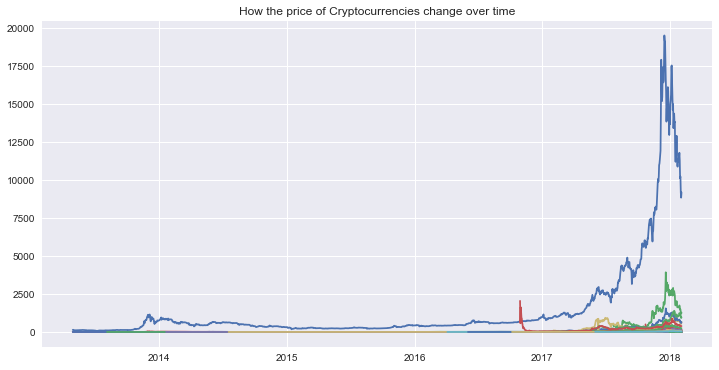

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
g = df.groupby('currency')

for label, data in g:
    ax.plot(data.Date, data.Close, label=label)
    
ax.set_title("How the price of Cryptocurrencies change over time")
plt.show()

### 정규화한 가격 비교
비트코인의 가격이 타 코인에 비해 훨씬 높아 패턴 비교가 어렵다. MinMaxScaler로 코인별 저점과 고점을 정규화한 후 비교해보자.
이전 차트와 다르게 훨씬 더 다양한 패턴이 보인다. 'namecoin'이라는 코인은 2014년에 최고점을 찍었고, 'bitcoin-gold'는 시작할때 기록한 최고점을 결국 경신하지 못했다.

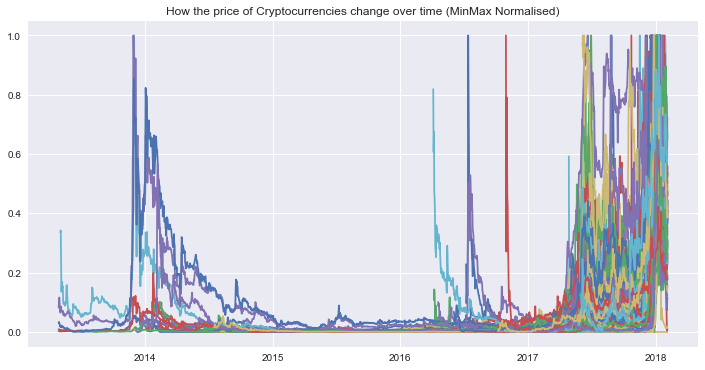

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
g = df.groupby('currency')

for label, data in g:
    data['Close_mn'] = mns.fit_transform(data.Close)
    ax.plot(data.Date, data.Close_mn, label=label)
    
ax.set_title("How the price of Cryptocurrencies change over time (MinMax Normalised)")
plt.show()

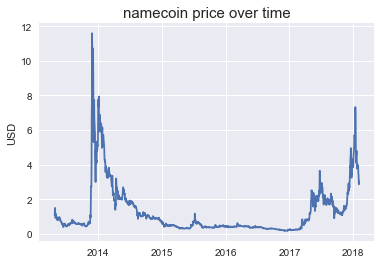

In [27]:
fig, ax = plt.subplots()
sdf = df[lambda x: x.currency == 'namecoin']
ax.plot(sdf.Date, sdf.Close)
ax.set_title("namecoin price over time", fontsize=15)
ax.set_ylabel("USD")
plt.show()

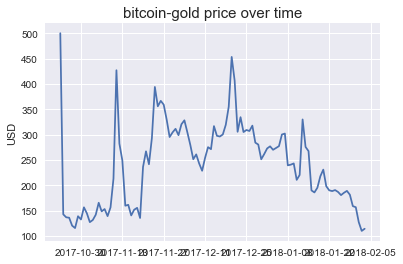

In [28]:
fig, ax = plt.subplots()
sdf = df[lambda x: x.currency == 'bitcoin-gold']
ax.plot(sdf.Date, sdf.Close)
ax.set_title("bitcoin-gold price over time", fontsize=15)
ax.set_ylabel("USD")
plt.show()

### 하이먼 민스키 테스트
코인별로 하이먼 민스키 차트와의 distance를 계산해보자.

In [29]:
res = []
g = df.groupby('currency')
for label, data in g:
    tmp = {}
    data_normed = mns.fit_transform(data.Close)
    distance, path = fastdtw(data_normed, minsky_df.adj_y, dist=euclidean)
    tmp['currency'] = label
    tmp['distance'] = distance
    res.append(tmp)

In [30]:
dist_df = pd.DataFrame(res)
dist_df.set_index('currency', inplace=True)

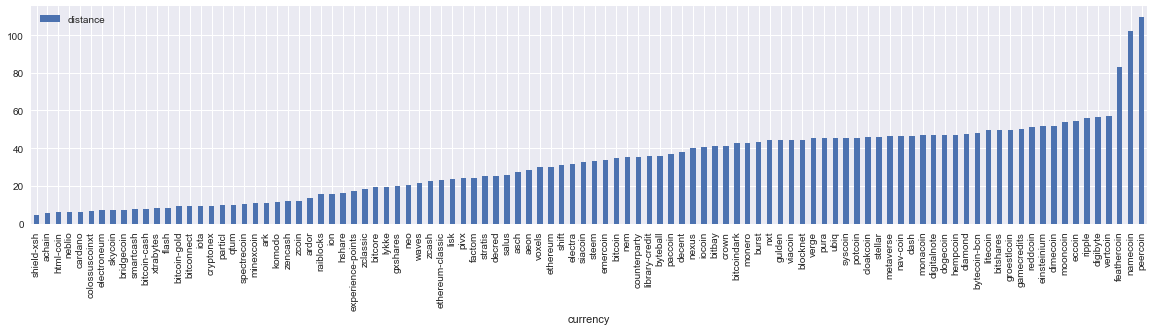

In [31]:
fig, ax = plt.subplots(figsize=(20, 4))
bars = dist_df.sort_values(by='distance').plot(kind='bar', ax=ax)

plt.show()

distance가 34 정도인 bitcoin은 중간 정도에 위치해있다. distance가 작거나 큰 5개의 차트를 살펴보자.

In [32]:
low_dist5 = dist_df.sort_values(by='distance').head(5).index.tolist()
high_dist5 = dist_df.sort_values(by='distance', ascending=False).head(5).index.tolist()

### Coins close to Hyman Minsky
하이먼 민스키 패턴과 가장 가까운 코인들이다.

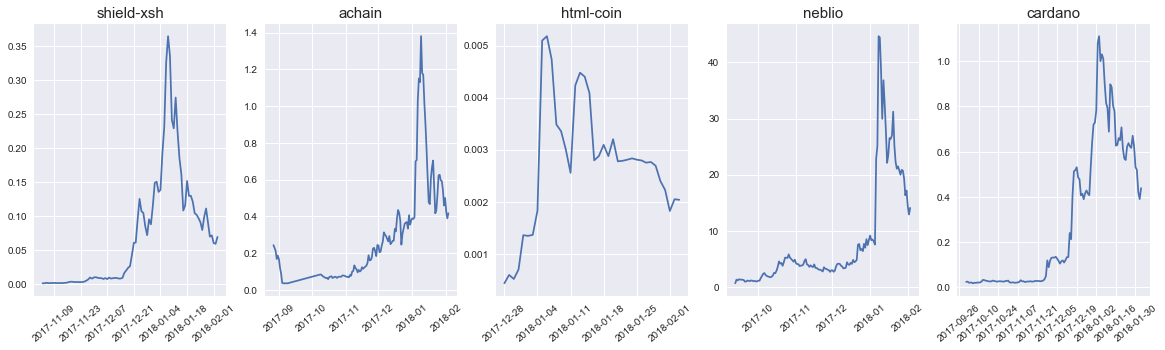

In [33]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for idx, cur in enumerate(low_dist5):
    sdf = df[lambda x: x.currency == cur]
    sdf.set_index(sdf.Date, inplace=True)
    
    ax[idx].plot(sdf.Close)
    ax[idx].set_title(cur, fontsize=15)
    
    for tick in ax[idx].get_xticklabels():
        tick.set_rotation(40)
plt.show()

### Coins far from Hyman Minsky
하이먼 민스키 패턴과 가장 거리가 먼 코인들이다. 투자 기회? 라고 보기에는 애매하다. 후반부는 하이먼 민스키 패턴을 보이지만, 전반부의 큰 피크로 인해 디스턴스가 높게 나온 것으로 보인다.

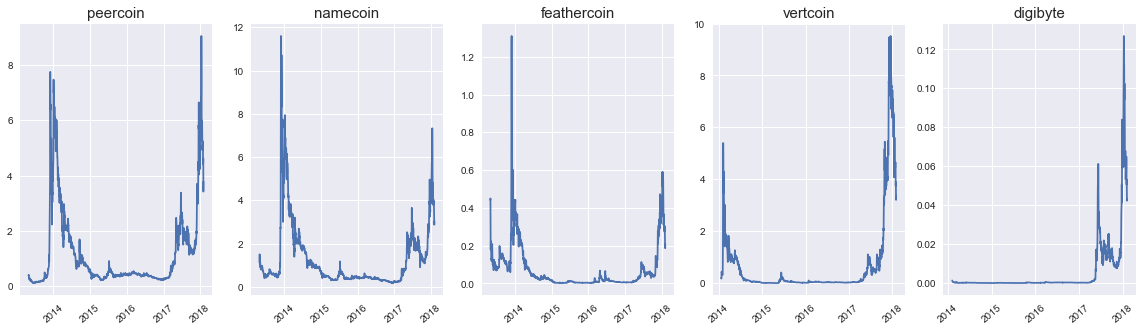

In [34]:
import matplotlib.dates as mdates
years = mdates.YearLocator() 
months = mdates.MonthLocator()

fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for idx, cur in enumerate(high_dist5):
    sdf = df[lambda x: x.currency == cur]
    sdf.set_index(sdf.Date, inplace=True)
    
    ax[idx].plot(sdf.Close)
    ax[idx].set_title(cur, fontsize=15)
    
    ax[idx].xaxis.set_major_locator(years)

    for tick in ax[idx].get_xticklabels():
        tick.set_rotation(40)
plt.show()

## Outro

Dynamic Time Warping을 사용해서 비트코인을 저점을 찾거나 투자할만한 코인을 발견하지는 못했지만, 암호화폐의 가격이 대략적으로 하이먼 민스키 패턴과 비슷하다는 점, 그리고 국소적으로도 하이먼 민스키 패턴을 발견할 수 있었던 점은 즐거운 지적 유희였다. 이래서 돈을 못버나보다 ㅠ

## Reference 
[1] https://www.reuters.com/article/us-china-congress-debt-minskymoment/china-central-bank-warns-against-minsky-moment-due-to-excessive-optimism-idUSKBN1CO0D6

[2] https://www.economist.com/news/economics-brief/21702740-second-article-our-series-seminal-economic-ideas-looks-hyman-minskys

[3] https://stackoverflow.com/questions/4809577/correlation-of-two-variables-in-a-time-series-in-python

[4] https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array

[5] Information Retrieval for Music and Motion by Meinard Müller

[6] https://pdfs.semanticscholar.org/05a2/0cde15e172fc82f32774dd0cf4fe5827cad2.pdf

[7] http://www.cs.ucr.edu/~eamonn/UCRsuite.html